In [1]:
import django
import pandas as pd
import requests
django.setup()

import os
from pprint import pprint
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from sch.models import *
import datetime as dt
from django.db.models import CharField
from django.db.models.functions import Cast
from django.test import RequestFactory
from sch.actions import *
from sch.views2 import *
from django.db.models import Sum

In [4]:
josh_op = Slot.objects.filter(employee__name='Josh',shift__name='OP', schedule__status=1)
print([op.workday.days_away for op in josh_op])

[-90]


In [12]:
def schUndertimeList(request, schId):
    sch = Schedule.objects.get(slug=schId)
    n_solved = 0
    maxes = sch.data['maxes']
    for e in sch.employees.all():
        if e.slug not in maxes:
            maxes[e.slug] = e.std_wk_max
        else:
            maxes[e.slug] = int(maxes[e.slug])
    print (maxes)
    
    print ("TOTAL # EMPTY", sch.slots.empty().count()) 
    
    for wk in sch.weeks.all():
        current = {e.slug: sum(list(wk.slots.filter(employee__slug=e).values_list('shift__hours',flat=True))) for e in sch.employees.all()}
        under = sortDict({e: maxes[e]-current.get(e,0) for e in current.keys() if current[e] < maxes[e]}, reverse=True)
        
        for empty_slot in wk.slots.empty():
            empty_slot.save()
            possible_fills = list(empty_slot.fills_with.all().values_list('slug',flat=True))
            print ('possible fills', possible_fills)
            for u in list(under.keys()):
                if u in possible_fills:
                    empty_slot.employee = Employee.objects.get(slug=u)
                    empty_slot.save()
                    print(f'replacing empty slot on {empty_slot.workday} with {str(empty_slot.employee)} for {empty_slot.shift} hours')
                    
                    under[u] = under[u] - empty_slot.shift.hours 
                    if under[u] <= 0:
                        under.pop(u)
                    print (under)
                    n_solved += 1
                    break
                else:
                    print (u, 'not in', possible_fills)
    print(n_solved)
        
    
schUndertimeList(None, '2023-S2A')

{'Blake': 20, 'Leslie': 30, 'Lindsay': 0, 'Mark': 0, 'Nick': 0, 'Trisha': 20, 'Amanda': 40, 'Brianna-A': 40, 'Brittanie': 40, 'Cheryl': 40, 'Danica': 40, 'David': 40, 'Elisia': 40, 'Esperanza': 40, 'Jaden': 40, 'Josh': 20, 'Mandy': 40, 'Michael': 40, 'Mona': 40, 'Sabrina': 40, 'Teddy': 40, 'Tiffany': 40}
TOTAL # EMPTY 12
possible fills ['Mona']
Brianna-A not in ['Mona']
Michael not in ['Mona']
Leslie not in ['Mona']
Mandy not in ['Mona']
Teddy not in ['Mona']
Brittanie not in ['Mona']
Cheryl not in ['Mona']
David not in ['Mona']
Esperanza not in ['Mona']
Jaden not in ['Mona']
Trisha not in ['Mona']
possible fills ['Mona']
Brianna-A not in ['Mona']
Michael not in ['Mona']
Leslie not in ['Mona']
Mandy not in ['Mona']
Teddy not in ['Mona']
Brittanie not in ['Mona']
Cheryl not in ['Mona']
David not in ['Mona']
Esperanza not in ['Mona']
Jaden not in ['Mona']
Trisha not in ['Mona']
possible fills ['Lindsay']
Brianna-A not in ['Lindsay']
Michael not in ['Lindsay']
Leslie not in ['Lindsay']
Ma

In [12]:
def solve_most_needed_hours (self, instance):
    instance.save()
    potential_employees = instance.fills_with.annotate(
        currentHours = Sum(instance.week.slots.filter(employee=OuterRef('pk')).values('shift__hours'))).annotate(
        diff =  F('std_wk_max') - F('currentHours') 
        ).potential_employees.order_by('-diff')
    if potential_employees.exists():
        instance.employee = potential_employees[0]
        instance.save()

Tiffany currentHours: 10.0 weeklyMax: 40 needed: 30.0


In [15]:
tallies = tally(list(Slot.objects.filled().filter(shift__name="OP").values_list('employee__name',flat=True)))
df = pd.DataFrame.from_dict(sortDict(tallies,reverse=True), orient='index', columns=['count'])
df


,count
Brittanie,276
Leslie,7
Trisha,5
Josh,4


<AxesSubplot:title={'center':'OP Tally'}>

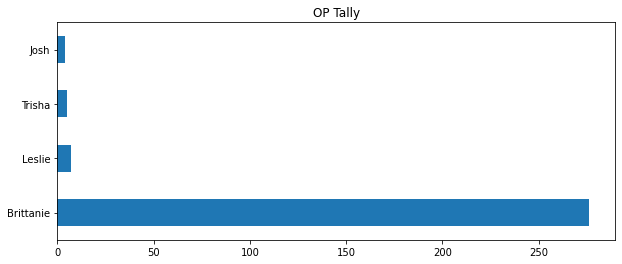

In [16]:
df.plot(figsize=(10,4),title='OP Tally',kind='barh',legend=False)

In [22]:
sch = Schedule.objects.first()

#scheduleHours, query slots that match employee and schedule = sch , then sum the shift__hours
empls = Employee.objects.annotate(scheduleHours=Sum('slots__shift__hours',filter=Q(slots__schedule=sch))).order_by('-scheduleHours')
# standard schedule Hours should be 240 * the employees fte field
empls = empls.annotate(standardScheduleHours=240*F('fte'))
empls = empls.annotate(percentScheduled=F('scheduleHours')/F('standardScheduleHours')*100)

data = empls.values(
    'name',
    'scheduleHours',
    'standardScheduleHours',
    'percentScheduled'
    )

df = pd.DataFrame.from_records(data)
df

,name,scheduleHours,standardScheduleHours,percentScheduled
0,Elisia,260.0,240.0,108.333333
1,Mona,240.0,240.0,100.000000
2,Blake,220.0,0.0,NaN
3,Esperanza,220.0,240.0,91.666667
4,Jaden,220.0,240.0,91.666667
5,Brittanie,216.0,240.0,90.000000
6,Danica,210.0,240.0,87.500000
7,Cheryl,200.0,240.0,83.333333
8,David,200.0,240.0,83.333333
9,Brianna A,180.0,240.0,75.000000


In [6]:
def sch_solve_with_lookbehind (request, schid):
    sch = Schedule.objects.get(slug=schid)
    success_bucket = []
    emptySlots = sch.slots.empty().order_by('?')
    for slot in emptySlots:
        if slot.workday.sd_id != 0:
            prev = slot.workday.prevWD().slots.filter(shift__start__hour__lte=slot.shift.start.hour+1, shift__start__hour__gte=slot.shift.start.hour-1)
            choices = []
            for p in prev:
                if p.streak < p.employee.streak_pref and p.employee not in choices and p.employee in slot.workday.on_deck():
                    choices.append(p.employee)
            if len(choices) > 0:
                chosen = random.choice(choices)
                if PtoRequest.objects.filter(employee=chosen, workday=slot.workday.date).exists() == False:
                    if TemplatedDayOff.objects.filter(employee=chosen, sd_id=slot.workday.sd_id).exists() == False:
                        try:
                            slot.employee = chosen
                            slot.save()
                            success_bucket.append(slot)
                        except:
                            print(f"ERROR: {slot} could not be filled")
                    else: 
                        print(f"{chosen} has a templated day off on {slot.workday.date}")
                else:
                    print(f"{chosen} has a PTO request on {slot.workday.date}")
            else:
                print(f"No choices for {slot}")
                try:
                    slot.employee = random.choice(workday.on_deck())
                    slot.save()
                    success_bucket.append(slot)
                except:
                    print(f"ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. {slot}")
        else:
            print(f"{slot} is on First Sunday of Schedule")
    print(len(success_bucket) , "slots filled via method SCHEDULE_SOLVE_WITH_LOOKBEHIND")
                    

In [16]:
def emusr_distr (request, schId):
    sch = Schedule.objects.get(slug=schId)
    print (f"SCHEDULE: {sch}")
    n_pm = sch.slots.evenings().count()
    print (f"# EVENING SHIFTS: {n_pm}")
    pm_empls = Employee.objects.filter(
        time_pref__in=["PM", "XN"]
    )
    pm_empls_shifts = sum(list(pm_empls.values_list("fte", flat=True))) * 40 * 6
    print (f"{pm_empls_shifts} HRS OF EVENING SHIFTS FILLED BY PM EMPLOYEES")
    remaining_pm = n_pm - pm_empls_shifts
    full_template_empls = Employee.objects.full_template_employees().values("pk")
    am_empls_fte_sum = sum(
        list(
            Employee.objects.filter(time_pref__in=["AM"])
            .exclude(pk__in=full_template_empls)
            .values_list("fte", flat=True)
        )
    )
    print (f'{am_empls_fte_sum}   TOTAL-FTE OF MORNING EMPLOYEES')
    unfavorables = sch.slots.unfavorables().values("employee")
    unfavorables = unfavorables.annotate(
        count=Value(1, output_field=IntegerField())
    )
    unfavorables = unfavorables.values("employee").annotate(count=Sum("count"))
    for u in unfavorables:
        print("    ", u['employee'], ":", u['count'])
    emusr_differences = list(unfavorables.values_list("count", flat=True))
    
    while None in emusr_differences:
        emusr_differences.remove(None)
        emusr_differences.append(0)
    if len(emusr_differences) == 0:
        emusr_differences.append(0)
        
    return max(emusr_differences) - min(emusr_differences)

In [17]:
emusr_distr (None, '2023-S2A')

SCHEDULE: 2023-S2A
# EVENING SHIFTS: 168
1260.0 HRS OF EVENING SHIFTS FILLED BY PM EMPLOYEES
6.125   TOTAL-FTE OF MORNING EMPLOYEES
     Cheryl : 2
     David : 6
     Josh : 3
     Teddy : 4
     Tiffany : 2
     Trisha : 4


4

In [18]:
def tallyPlotDataGenerator (request, empId):    
    from django.db.models import Count, OuterRef, Subquery
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import urllib
    import base64
    from io import BytesIO
    import seaborn as sns
    import matplotlib.pyplot as plt
    from django.db.models import Sum
    # define a subquery that counts the occurrences of each employee/shift combination in the Slot model
    subquery = Subquery(
        Slot.objects.filter(
                employee=OuterRef('employee'),
                shift=OuterRef('shift')
            ).values('employee', 'shift').annotate(
                count=Count('*')
            ).values('count')[:1],
            output_field=models.IntegerField()
            )
    # Count n of Slots, then if A ShiftPreference exists for that employee/shift combination
    emp = Employee.objects.get(name=empId)
    shift_prefs = emp.shift_prefs.annotate(count=subquery)

    score_subquery = Subquery(
                    Slot.objects.filter(
                        employee=OuterRef('employee'),
                        shift=OuterRef('shift'),
                    ).values('employee', 'shift', 'employee__shift_prefs__priority').annotate(
                        count=Count('*')
                    ).values('count')[:1],
                    output_field=models.IntegerField()
                )
    sps = shift_prefs.annotate(
        pref_score=Subquery(
            ShiftPreference.objects.filter(
                employee=OuterRef('employee'),
                shift=OuterRef('shift')
            ).values('score')[:1]
        )
    ).annotate(
        score_count=Coalesce(score_subquery, 0)
            ).values('score').annotate(
        count=Sum('score_count')
            ).order_by('score')
            
    data = []
    for j in sps:
        for n in range(j['count']):
            data.append(j['score'])
    

    sns.kdeplot(data=data, fill=True, bw_adjust=1.5, cut=4, label=f'{emp.name}')
    sns.set_theme('paper',"dark")
    plt.style.use('dark_background')
    # change x label to "Dislike" at -3 and "Prefer" at 3
    plt.xticks([-3, 0, 3], ['Dislike', 'Neutral', 'Prefer'])
    
    
    emp = Employee.objects.get(name=empId)
    #change x labels to be from Dislike to Prefer
    plt.xticks([-2.5,2.5], ['Dislike','Prefer'])
    plt.title(f'{emp.name}\'s Shift Preference Distribution')
    # save the figure to a buffer as SVG
    plt.legend(loc='upper left')
    buf = BytesIO()
    
    plt.savefig(buf, format='png')
    # get the SVG contents as bytes and encode to base64
    svg_bytes = buf.getvalue()
    svg_base64 = base64.b64encode(svg_bytes).decode('utf-8')
    buf.close()

    return HttpResponse(svg_html)


In [19]:
from flow import views as flow_views

def select_max_min_employees (request, schId, exclude=[] ):
    emusr_data = flow_views.ApiViews.schedule__get_emusr_list(request,schId)
    data = json.loads(emusr_data.content)
    if exclude != []:
        for e in exclude:
            data.pop(e, None)
    max_val = max(data.values())
    max_empl = [k for k, v in data.items() if v == max_val][0]
    min_val = min(data.values())
    min_empl = [k for k, v in data.items() if v == min_val][0]
    return (max_empl, min_empl)
        
def get_tradable_slots (request, schId, emplA, emplB):
    tradables = []
    sch = Schedule.objects.get(slug=schId)
    # get evening slots of emplA, where emplB is in a morning slot on the same day 
    pmSlots = sch.slots.filter(employee__name=emplA, shift__group__in=['PM','XN'])
    for slot in pmSlots:
        if slot.workday.slots.filter(employee__name=emplB, shift__group__in=['AM']).exists():
            tradables.append(slot.pk)
    tradables = Slot.objects.filter(pk__in=tradables)
    print(f'Potenital Trades: {tradables.count()}')
    # filter out exceptions
    for slot in tradables:
        if slot.workday.sd_id != 41:
            if slot.workday.nextWD().slots.filter(employee__name=emplA, shift__group__in=['AM']).exists():
                tradables = tradables.exclude(pk=slot.pk)
                print(f'Slot Excluded because {emplA} has an AM shift on the next day')
        if slot.workday.sd_id != 0:
            if slot.workday.prevWD().slots.filter(employee__name=emplB, shift__group__in=['PM','XN']).exists():
                tradables = tradables.exclude(pk=slot.pk)
                print(f'Slot Excluded because {emplB} has a PM shift on the previous day')
        if not slot.shift.trained.filter(name=emplB).exists():
            tradables = tradables.exclude(pk=slot.pk)
            print(f'Slot Excluded because {emplB} is not trained for {slot.shift}')
        

    return tradables

In [20]:
maxEmpl, minEmpl = select_max_min_employees(None, '2023-S1A', ["Mandy","Blake"])
maxEmpl, minEmpl

DoesNotExist: Schedule matching query does not exist.

In [ ]:
get_tradable_slots(None, '2023-S1A', maxEmpl, minEmpl)

Potenital Trades: 1


<SlotManager [<Slot: 2023-02-07-EP>]>

In [ ]:
d = dict()
slot = Slot.objects.all()[500]
emps = Employee.objects.all().annotate(schHours=F('fte')*240).values('name','schHours')
for e in emps:
    d[e['name']] = e['schHours']
sch = slot.schedule
# for min in d get sch.slots.fills_with(min)
min_empl = min(d, key=d.get)
# exclude if empl is in slot on same day
for s in sch.slots.filter(employee__name=min_empl):
    if s.siblings_day.filter(employee__name=min_empl).exists():
        s.siblings_day.filter(employee__name=min_empl).update(fills_with__remove=[min_empl])


In [21]:
sch.actions.clearPmEmployeesAmShifts(sch)
sch.percent
startdates = sch.START_DATES
for yr, datelist in startdates.items():
    print(yr)
    print("".join([d.strftime("%Y-%m-%d, ") for d in datelist]))
    print()

2020
2020-02-09, 2020-03-22, 2020-05-03, 2020-06-14, 2020-07-26, 2020-09-06, 2020-10-18, 2020-11-29, 

2021
2021-01-10, 2021-02-21, 2021-04-04, 2021-05-16, 2021-06-27, 2021-08-08, 2021-09-19, 2021-10-31, 2021-12-12, 

2022
2022-01-23, 2022-03-06, 2022-04-17, 2022-05-29, 2022-07-10, 2022-08-21, 2022-10-02, 2022-11-13, 2022-12-25, 

2023
2023-02-05, 2023-03-19, 2023-04-30, 2023-06-11, 2023-07-23, 2023-09-03, 2023-10-15, 2023-11-26, 

2024
2024-01-07, 2024-02-18, 2024-03-31, 2024-05-12, 2024-06-23, 2024-08-04, 2024-09-15, 2024-10-27, 2024-12-08, 

2025
2025-01-19, 2025-03-02, 2025-04-13, 2025-05-25, 2025-07-06, 2025-08-17, 2025-09-28, 



In [22]:
def payPeriodFiller(schId):
    sch = Schedule.objects.get(slug=schId)
    for pd in sch.periods.all():
        empties = pd.slots.empty().all()
        print(f'Checking {empties.count()} slots')
        for e in empties:
            e.save()
            count = e.fills_with.count()
            if count > 0:
                print (e, '  checking...')
                empls = list(pd.needed_hours())
                for empl in empls:
                    print (empl)
                    if e.fills_with.filter(name=empl).exists():
                        if e.workday.slots.filter(employee=empl).exists() == False:
                            e.employee = empl
                            print ('    FILLING SLOT:', e, 'with', empl)
                            e.save()
                        else:
                            print ('    skipping employee because they already have a shift')
                    else:
                        print ('  skipping employee because they are not trained for this shift')
            else:
                print ('  skipping slot because it is already filled')



In [23]:
def workday_context (request, wdSlug):
    wd = Workday.objects.get(slug=wdSlug)
    
    tdo = [e.slug for e in wd.on_tdo()]
    pto = [e.slug for e in wd.on_pto()]
    deck= [e.slug for e in wd.on_deck()]
    working= [e for e in wd.slots.values_list('employee__slug', flat=True)]
    weekHours = { e.slug: e.weekHours(wd) for e in wd.schedule.employees.all() if e != None }
    periodHours = { e.slug: e.periodHours(wd) for e in wd.schedule.employees.all() if e != None }

    d = { wd.slug: {} }
    d[wd.slug]['tdo']        = tdo
    d[wd.slug]['pto']        = pto
    d[wd.slug]['deck']       = deck
    d[wd.slug]['working']    = working
    d[wd.slug]['week_hours'] = weekHours
    d[wd.slug]['periodHours']= periodHours
    
    return HttpResponse(json.dumps(d))

def http_response_as_json (response: HttpResponse):
    return (json.loads(response.content.decode('utf-8')))

h2json = lambda r : pprint (http_response_as_json(r))

In [26]:
resp = workday_context(None, '2023-02-28B')

h2json(resp)

DoesNotExist: Workday matching query does not exist.

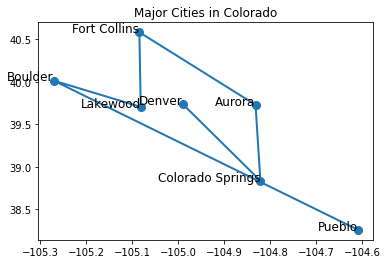

In [ ]:
import matplotlib.pyplot as plt

# List of major cities in Colorado with their coordinates (latitude, longitude)
cities = {
    "Denver": (39.7392, -104.9903),
    "Colorado Springs": (38.8339, -104.8214),
    "Aurora": (39.7294, -104.8319),
    "Fort Collins": (40.5853, -105.0844),
    "Lakewood": (39.7047, -105.0814),
    "Boulder": (40.01499, -105.27055),
    "Pueblo": (38.2544, -104.6091),
}

# Unpack city coordinates into separate lists for plotting
latitudes, longitudes = zip(*cities.values())

# Plot and connect the cities
fig, ax = plt.subplots()
ax.plot(longitudes, latitudes, marker='o', linestyle='-', linewidth=2, markersize=8)
ax.set_title("Major Cities in Colorado")

# Annotate city names
for city, (lat, lon) in cities.items():
    ax.text(lon, lat, city, fontsize=12, ha='right')

# Show the plot
plt.show()


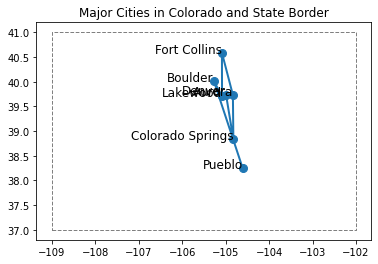

In [ ]:
import matplotlib.pyplot as plt

# List of major cities in Colorado with their coordinates (latitude, longitude)
cities = {
    "Denver": (39.7392, -104.9903),
    "Colorado Springs": (38.8339, -104.8214),
    "Aurora": (39.7294, -104.8319),
    "Fort Collins": (40.5853, -105.0844),
    "Lakewood": (39.7047, -105.0814),
    "Boulder": (40.01499, -105.27055),
    "Pueblo": (38.2544, -104.6091),
}

# Unpack city coordinates into separate lists for plotting
latitudes, longitudes = zip(*cities.values())

# Plot and connect the cities
fig, ax = plt.subplots()
ax.plot(longitudes, latitudes, marker='o', linestyle='-', linewidth=2, markersize=8)

# Annotate city names
for city, (lat, lon) in cities.items():
    ax.text(lon, lat, city, fontsize=12, ha='right')

# Draw a rectangle around the border of Colorado
colorado_border_coordinates = [
    (37, -109), 
    (37, -102), 
    (41, -102), 
    (41, -109), 
    (37, -109)
]
border_latitudes, border_longitudes = zip(*colorado_border_coordinates)
ax.plot(border_longitudes, border_latitudes, linestyle='--', linewidth=1, color='gray')

ax.set_title("Major Cities in Colorado and State Border")


# Show the plot
plt.show()


In [ ]:
from django.db.models import Subquery, OuterRef

employee = Employee.objects.get(slug='Josh')
shift_score_subquery = employee.shift_prefs.filter(shift=OuterRef('shift')).values('score')[:1]

slots = Slot.objects.filter(employee=employee).annotate(score=Subquery(shift_score_subquery))

df = pd.DataFrame(slots.values('employee__name','slug','shift__name','schedule','score'))
Schedule.objects.get(id=180)

<Schedule: 2023-S2B>